In [194]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product 
%matplotlib inline 

import holoviews as hv
hv.notebook_extension()

%output holomap='scrubber', max_frames = 10000

In [142]:
def find_av_theta(N, theta, positions, L, r):
    r_vec = positions[None, :] - positions[:, None]
    r_vec = r_vec - np.rint(r_vec / L) * L
    r_abs = np.linalg.norm(r_vec, axis=2)
    
    av_neigh_sin = np.array([np.mean(np.sin(theta[r_abs[i, :] < r])) for i in range(N)])
    av_neigh_cos = np.array([np.mean(np.cos(theta[r_abs[i, :] < r])) for i in range(N)])
    av_neigh_theta = np.arctan2(av_neigh_sin, av_neigh_cos)

    return av_neigh_theta

def simulate(N, steps, dt, L, v_abs, r, eta):
    #   System variables
    x = np.zeros(shape=(steps, N, 2))
    theta = np.zeros(shape=(steps, N))
    v = np.zeros(shape=(steps, N, 2))

    #   Initialize 
    x[0, :, :] = np.random.uniform(0, L, size=(N, 2))
    theta[0, :] = np.random.uniform(-np.pi, np.pi, size=N)
    v[0, :, 0] = v_abs * np.cos(theta[0, :])
    v[0, :, 1] = v_abs * np.sin(theta[0, :])  
    
    for i in range(steps-1):
        av_neighbour_theta = find_av_theta(N, theta[i, :], x[i, :], L, r)
        theta[i+1, :] = av_neighbour_theta + np.random.uniform(-eta/2, eta/2, size=N) 
        v[i+1, :, 0] = v_abs * np.cos(theta[i+1, :])
        v[i+1, :, 1] = v_abs * np.sin(theta[i+1, :])  
        x[i+1, :, :] = np.mod(x[i, :, :] + v[i, :, :] * dt, L)

    return x, v, theta

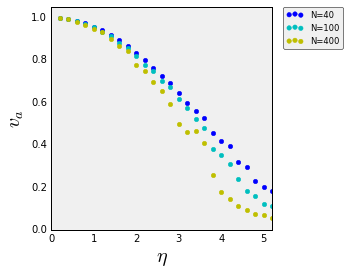

In [459]:
#   Calculate v_a vs eta for different number of particles at constant rho
eta_values = np.arange(0.2, 6, 0.2)
N_values = [40, 100, 400]
L_values = [3.16, 5, 10]
v_abs = 0.3
steps = 500
dt = 0.1
r = 1

v_a = {N:[] for N in N_values}
csi = {N:[] for N in N_values}

for N, L in zip(N_values, L_values):
    for eta in eta_values:
        x, v, theta = simulate(N, steps, dt, L, v_abs, r, eta)

    #     for i in range(steps):
    #         if i%100 == 0:
    #             plt.quiver(x[i, :, 0], x[i, :, 1], v[i, :, 0], v[i, :, 1])
    #             plt.show()

        v_a_samples = np.linalg.norm(np.mean(v[int(steps/2):steps, :, :], axis=1), axis=1)/v_abs
        v_a[N].append(np.mean(v_a_samples))
        
fig = plt.figure()
ax = fig.add_subplot(111)
colors = ['b', 'c', 'y', 'm', 'r']

for index, N in enumerate(N_values):
    plt.scatter(eta_values, v_a[N], label="N="+str(N), color=colors[index])

ax.set_xlim([0, 5.2])
ax.set_ylim([0, 1.05])
ax.set_aspect(5)

plt.xlabel('$\\eta$', fontsize=20)
plt.ylabel('$v_a$', fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

9.5
3.6
0.95
[ 0.29357695  0.01697571]


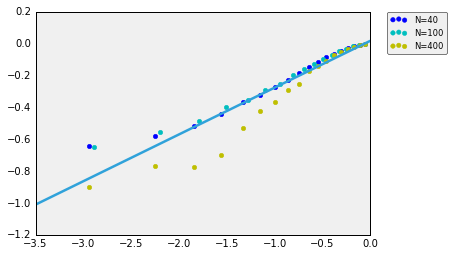

In [460]:
#    Finite size scaling for beta exponent

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim([-3.5, 0])   
colors = ['b', 'c', 'y', 'm', 'r']

x_fit_points = []
y_fit_points = []

for index, N in enumerate(N_values):
     #    Some fluctuations may cause positive gradients, which we set to 0
    grad = np.gradient(v_a[N]) 
    grad[grad>0] = 0
    abs_grad = np.abs(grad)
    critical_eta = eta_values[np.argmax(abs_grad)]
    
    #    Consider eta_values below the critical value
    new_eta_values = eta_values[eta_values<critical_eta]

    x_points = np.log((critical_eta - new_eta_values)/critical_eta)
    y_points = np.log(np.array(v_a[N])[eta_values<critical_eta])
    x_fit_points.extend(x_points)
    y_fit_points.extend(y_points)
    print(critical_eta/(N/L**2))
    plt.scatter(x_points, y_points, label="N="+str(N), color=colors[index])

fit = np.polyfit(x_fit_points, y_fit_points, 1)
print(fit)

xp = np.linspace(-3.5, 0, 100)
plt.plot(xp, np.poly1d(fit)(xp))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()


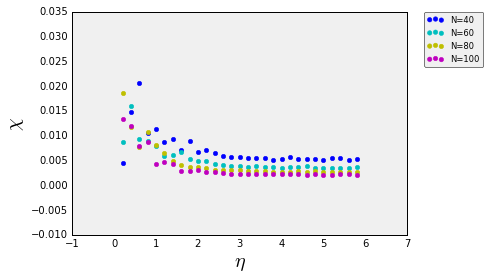

In [492]:
eta_values = np.arange(0.2, 6, 0.2)
rho = 1/8
N_values = [40, 60, 80, 100]
L_values = [np.sqrt(N)/rho for N in N_values]

v_abs = 0.3
steps = 10000
dt = 0.1
r = 1

csi = {N:[] for N in N_values}

for N, L in zip(N_values, L_values):
    for eta in eta_values:
        x, v, theta = simulate(N, steps, dt, L, v_abs, r, eta)
        v_a_samples = np.linalg.norm(np.mean(v[int(steps/2):steps, :, :], axis=1), axis=1)/v_abs
        csi[N].append(np.var(v_a_samples))
        
fig = plt.figure()
ax = fig.add_subplot(111)
colors = ['b', 'c', 'y', 'm', 'r']

for index, N in enumerate(N_values):
    plt.scatter(eta_values, csi[N], label="N="+str(N), color=colors[index])

plt.xlabel('$\\eta$', fontsize=20)
plt.ylabel('$\\chi$', fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()